## Libraries 

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
from torch.nn import Linear, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, ToPILImage, RandomApply, RandomHorizontalFlip, RandomAffine, RandomErasing

## Prepare training data

In [2]:
train_df = pd.read_csv("./input/stage_1_train.csv")

# --------- One-hot-encode labels ---------
train_df[["ID", "Image", "Diagnosis"]] = train_df["ID"].str.split("_", expand = True) # 6 rows per image
train_df = train_df.drop("ID", axis = 1)
train_df = train_df.drop_duplicates()
train_df = train_df.pivot(index = "Image", columns = "Diagnosis", values = "Label") # one-hot-encode the label
train_df = train_df.reset_index()
train_df = train_df.rename_axis(None, axis = 1)
train_df["Image"] = "ID_" + train_df["Image"]

# --------- Remove IDs with no image ---------
imgs_found = glob.glob("./input/train/*.png") # get list of img paths
imgs_found = [os.path.basename(img_path)[:-4] for img_path in imgs_found] # convert to list of IDs

train_df = train_df[train_df["Image"].isin(imgs_found)] # filter train_df with list

train_df.head()

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [3]:
train_df, val_df = train_test_split(
        train_df,
        shuffle = True,
        test_size = 0.15,
        random_state = 2019
)

## Data Generators 

In [4]:
class HemorrhageDataset(Dataset):    
    def __init__(self, df, img_path, labels = True, augmentations = None):    
        self.df = df
        self.img_path = img_path
        self.augmentations = augmentations
        self.labels = labels

    def __len__(self):        
        return len(self.df)

    def __getitem__(self, index):        
        img_id = self.df.iloc[index, 0]
        img = cv2.imread(self.img_path + img_id + ".png")   
        
        if self.augmentations is not None:                  
            img = self.augmentations(img)
            
        if self.labels == True:     
            label = torch.tensor(self.df.iloc[index, [2, 3, 4, 5, 6, 1]]) # column order is relevant
            return img, label       
        else:                  
            return img
  
augs_train = Compose([
        ToPILImage(),
        RandomHorizontalFlip(p = 0.4),
        RandomApply([RandomAffine(degrees = 20, scale = (0.75, 0.9), shear = 20)], p = 0.4),
        ToTensor(), # also scales to 0...1
        RandomErasing(scale = (0.01, 0.10), ratio = (0.5, 1.5), p = 0.3)
])

augs_val = Compose([
        ToPILImage(),       
        ToTensor(),
])

train_dataset = HemorrhageDataset(train_df, "./input/train/", augmentations = augs_train)
val_dataset = HemorrhageDataset(val_df, "./input/train/", augmentations = augs_val)

batch_size = 32

train_gen = DataLoader(train_dataset, batch_size)
val_gen = DataLoader(val_dataset, batch_size)

## Visualize data 

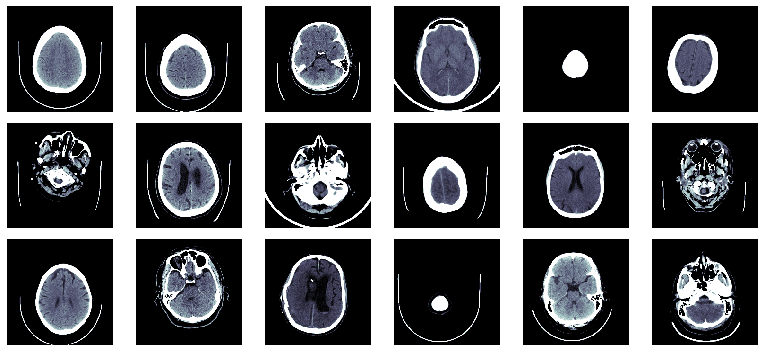

In [8]:
imgs, _ = next(iter(val_gen))
imgs = imgs.numpy().transpose(0, 2, 3, 1) # reshape (n, ch, h, w) to (n, h, w, ch)

fig = plt.figure(figsize = (11, 5))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    img = imgs[i, :, :, 0] # select first channel
    plt.imshow(img, cmap = "bone")
    plt.axis("off")
plt.tight_layout() 

## Specify model 

In [ ]:
device = torch.device("cuda:0")

n_classes = 6
 
class EfficientNetB0(nn.Module):        
    def __init__(self):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained("efficientnet-b0") 
        self.model._fc = Linear(1280, n_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x

model = EfficientNetB0().to(device)

criterion = BCEWithLogitsLoss() # sigmoid layer + BCELoss
optimizer = Adam(model.parameters(), lr = 1e-4, betas = (0.9, 0.999))

## Fit model 

In [6]:
num_epochs = 5

for epoch_i in range(num_epochs):
    model.train() # set train mode
    train_loss = []
    val_loss = []
    
    for batch_i, (images, labels) in enumerate(tqdm(train_gen)):
        images = images.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.float)  
        optimizer.zero_grad() # clear gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())
        loss.backward() # compute gradient
        optimizer.step() # update parameters
    
    # ------------- Evaluation on validation data -------------
    model.eval() # set evaluation mode
    with torch.no_grad():
        for batch_i, (images, labels) in enumerate(val_gen):
            images = images.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.float)
            output = model(images)
            loss = criterion(output, labels)
            val_loss.append(loss.item()) 
        
    print(f"\n{epoch_i + 1} | Train loss: {np.mean(train_loss):.4f} | Val loss: {np.mean(val_loss):.4f}")

  0%|          | 1/17845 [00:00<54:22,  5.47it/s]


1 | Train loss: 0.0966 | Val loss: 0.0754


  0%|          | 1/17845 [00:00<53:55,  5.52it/s]


2 | Train loss: 0.0791 | Val loss: 0.0710


  0%|          | 1/17845 [00:00<54:02,  5.50it/s]


3 | Train loss: 0.0733 | Val loss: 0.0677


  0%|          | 1/17845 [00:00<54:21,  5.47it/s]


4 | Train loss: 0.0692 | Val loss: 0.0660


100%|██████████| 17845/17845 [54:36<00:00,  5.45it/s]



5 | Train loss: 0.0658 | Val loss: 0.0649


## Prepare test data 

In [7]:
test_df = pd.read_csv("./input/stage_1_sample_submission.csv")

test_df[["ID", "Image", "Diagnosis"]] = test_df["ID"].str.split("_", expand = True)
test_df["Image"] = "ID_" + test_df["Image"]
test_df = test_df[["Image", "Label"]]
test_df = test_df.drop_duplicates()

augs_test = Compose([
        ToPILImage(),
        RandomHorizontalFlip(p = 0.4),
        RandomApply([RandomAffine(degrees = 20, scale = (0.75, 0.9), shear = 20)], p = 0.4),
        ToTensor(),
])

test_dataset = HemorrhageDataset(test_df, "./input/test/", augmentations = augs_test, labels = False)
test_gen = DataLoader(test_dataset, batch_size)

## Prediction 

In [20]:
# --------- Test Time Augmentation ---------
model.eval()

preds = np.zeros((len(test_dataset) * n_classes, 5))

with torch.no_grad():
    for round_i in range(5):
        preds_round = np.zeros((len(test_dataset) * n_classes, 1))
        
        for batch_i, images in enumerate(test_gen):        
            images = images.to(device, dtype = torch.float)                   
            preds_batch = model(images) 
            preds_batch = torch.sigmoid(preds_batch).cpu() # scale to 0...1 and copy to host memory
            preds_batch = preds_batch.reshape((len(images) * n_classes, 1)) # reshape (32, 6) to (32*6, 1)
            preds_round[(batch_i * batch_size * n_classes):((batch_i + 1) * batch_size * n_classes)] = preds_batch
                
        preds[:, round_i] = preds_round.squeeze() # reshape (n, 1) to (n, ) first

np.around(preds[:10], 4)

array([[0.0004, 0.0001, 0.0004, 0.    , 0.0001],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0018, 0.0003, 0.0009, 0.0001, 0.0002],
       [0.0002, 0.0004, 0.0008, 0.0001, 0.    ],
       [0.0023, 0.0015, 0.0024, 0.0004, 0.0003],
       [0.0004, 0.0001, 0.0005, 0.0001, 0.0001],
       [0.0016, 0.0002, 0.0012, 0.0005, 0.0006],
       [0.0001, 0.    , 0.0001, 0.    , 0.0001],
       [0.0084, 0.0064, 0.0127, 0.003 , 0.0034]])

In [23]:
preds = np.mean(preds, axis = 1) # take average row-wise

np.around(np.reshape(preds[:10], (-1, 1)), 4)

array([[0.0002],
       [0.    ],
       [0.0006],
       [0.0003],
       [0.0014],
       [0.0003],
       [0.0008],
       [0.    ],
       [0.0068]])

## Submission 

In [26]:
subm_df = pd.read_csv("./input/stage_1_sample_submission.csv")
subm_df["Label"] = preds
subm_df.to_csv("submission.csv", index = False)

subm_df.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,0.000083
1,ID_28fbab7eb_intraparenchymal,0.000206
2,ID_28fbab7eb_intraventricular,0.000001
3,ID_28fbab7eb_subarachnoid,0.000644
4,ID_28fbab7eb_subdural,0.000300
5,ID_28fbab7eb_any,0.001375
6,ID_877923b8b_epidural,0.000261
7,ID_877923b8b_intraparenchymal,0.000825
8,ID_877923b8b_intraventricular,0.000048
9,ID_877923b8b_subarachnoid,0.006763
